In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
register_matplotlib_converters()
from time import time

In [52]:
def parser(s):
    return datetime.strptime(s,'%Y-%m-%d')

In [53]:
catfish_sales=pd.read_csv('catfish.csv',parse_dates=[0],index_col=0,date_parser=parser)

if len(catfish_sales.columns) == 1:
    catfish_sales = catfish_sales.squeeze()

catfish_sales

/var/folders/gx/p5qhhh8s7rg2_ywh443qwth80000gn/T/ipykernel_2731/969626329.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  catfish_sales=pd.read_csv('catfish.csv',parse_dates=[0],index_col=0,date_parser=parser)


Date
1986-01-01     9034
1986-02-01     9596
1986-03-01    10558
1986-04-01     9002
1986-05-01     9239
              ...  
2012-08-01    14442
2012-09-01    13422
2012-10-01    13795
2012-11-01    13352
2012-12-01    12716
Name: Total, Length: 324, dtype: int64

In [54]:
catfish_sales=catfish_sales.asfreq(pd.infer_freq(catfish_sales.index))

In [55]:
start_date=datetime(1996,1,1)
end_date=datetime(2000,1,1)
lim_catfish_sales=catfish_sales[start_date:end_date]

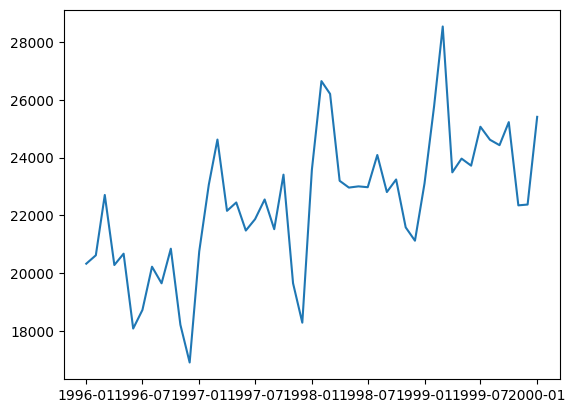

In [56]:
plt.plot(lim_catfish_sales)

In [57]:
first_diff=lim_catfish_sales.diff()[1:]

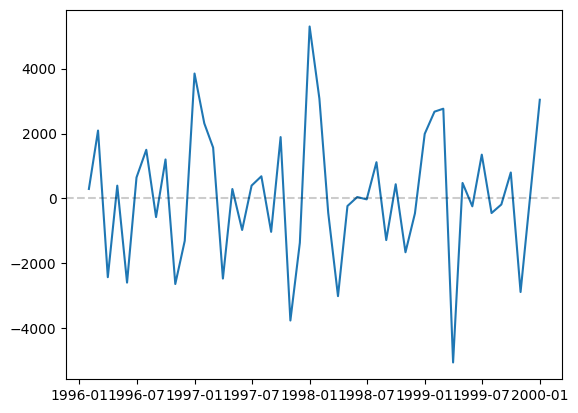

In [58]:
plt.plot(first_diff)
plt.axhline(0,color='k',linestyle='--',alpha=0.2)

<BarContainer object of 17 artists>

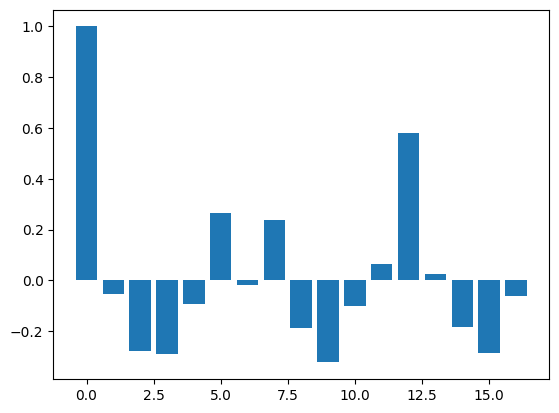

In [59]:
acf_values=acf(first_diff)
num_lags=17
plt.bar(range(num_lags),acf_values[:num_lags])


<BarContainer object of 17 artists>

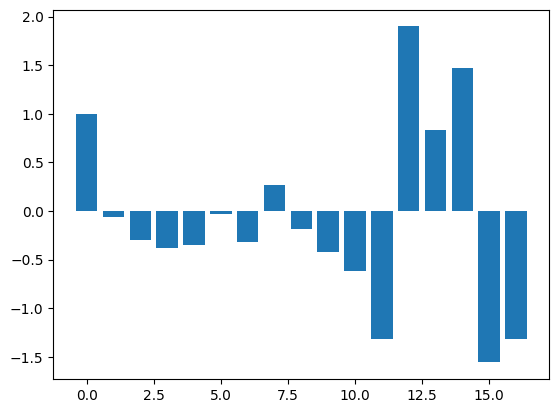

In [60]:
pacf_values=pacf(first_diff)
plt.bar(range(num_lags),pacf_values[:num_lags])

In [61]:
train_end=datetime(1999,7,1)
test_end=datetime(2000,1,1)

train_data=lim_catfish_sales[:train_end]
test_data=lim_catfish_sales[train_end+timedelta(days=1):test_end]


In [83]:
train_end

Timestamp('2000-01-01 00:00:00')

In [62]:
my_order=(0,1,0)#Cause theres only seasonal behaviour in the data
my_seasonal_order=(1,0,1,12)#In both acf and pacf graphs, 12 is a spike
model=SARIMAX(train_data,order=my_order,seasonal_order=my_seasonal_order)


In [63]:
start=time()
model_fit=model.fit()
end=time()

print("Model fitting time is:",end-start)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.87457D+00    |proj g|=  1.22901D+00

At iterate    5    f=  8.58202D+00    |proj g|=  3.02972D-01

At iterate   10    f=  8.55569D+00    |proj g|=  1.37702D-03

At iterate   15    f=  8.55568D+00    |proj g|=  1.04975D-03

At iterate   20    f=  8.55552D+00    |proj g|=  2.47963D-02

At iterate   25    f=  8.52558D+00    |proj g|=  1.34787D-01

At iterate   30    f=  8.50882D+00    |proj g|=  2.77196D-02

At iterate   35    f=  8.50325D+00    |proj g|=  1.66723D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


In [64]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                Total   No. Observations:                   43
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 12)   Log Likelihood                -365.635
Date:                              Tue, 30 Jul 2024   AIC                            737.269
Time:                                      12:36:55   BIC                            742.482
Sample:                                  01-01-1996   HQIC                           739.180
                                       - 07-01-1999                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.8250      0.120      6.848      0.000       0.589       1.061
ma.S.L12      -0.5187      0.197     -2.632      0.008      -0.905      -0.132
sigma2       1.78e+06    4.7e+05      3.791      0.000     8.6e+05     2.7e+06
===================================================================================
Ljung-Box (L1) (Q):                   2.82   Jarque-Bera (JB):                 1.13
Prob(Q):                              0.09   Prob(JB):                         0.57
Heteroskedasticity (H):               0.81   Skew:                            -0.30
Prob(H) (two-sided):                  0.70   Kurtosis:                         2.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [65]:
test_data
len(test_data)


6

In [71]:
predictions=model_fit.forecast(len(test_data))
residuals=test_data-predictions

In [72]:
predictions

1999-08-01    25695.480901
1999-09-01    25054.190452
1999-10-01    25642.867230
1999-11-01    24195.590224
1999-12-01    23677.332924
2000-01-01    26250.630934
Freq: MS, Name: predicted_mean, dtype: float64

In [73]:
test_data

Date
1999-08-01    24618
1999-09-01    24430
1999-10-01    25229
1999-11-01    22344
1999-12-01    22372
2000-01-01    25412
Freq: MS, Name: Total, dtype: int64

In [74]:
residuals

Date
1999-08-01   -1077.480901
1999-09-01    -624.190452
1999-10-01    -413.867230
1999-11-01   -1851.590224
1999-12-01   -1305.332924
2000-01-01    -838.630934
Freq: MS, dtype: float64

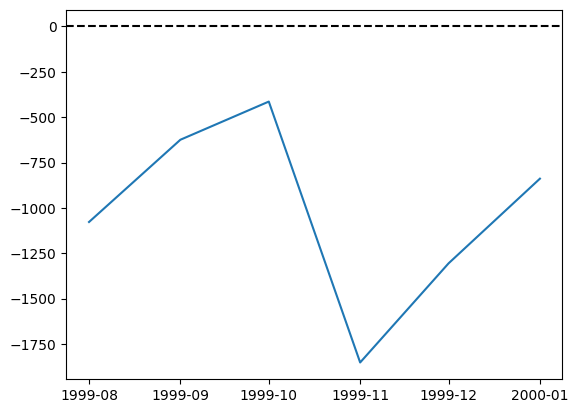

In [76]:
plt.plot(residuals)
plt.axhline(0,linestyle='--',color='k')

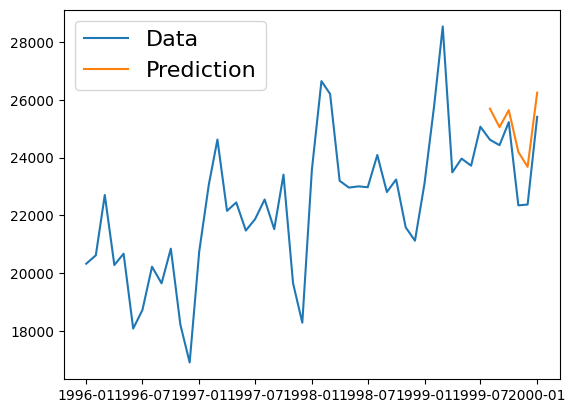

In [77]:
plt.plot(lim_catfish_sales)
plt.plot(predictions)
plt.legend(('Data','Prediction'),fontsize=16)

In [78]:
#Using rolling forecast origin

rolling_predictions=test_data.copy()
for train_end in test_data.index:
    train_data=lim_catfish_sales[:train_end-timedelta(days=1)]
    model=SARIMAX(train_data,order=my_order,seasonal_order=my_seasonal_order)
    model_fit=model.fit()

    pred=model_fit.forecast()
    rolling_predictions[train_end]=pred

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.87457D+00    |proj g|=  1.22901D+00

At iterate    5    f=  8.58202D+00    |proj g|=  3.02972D-01

At iterate   10    f=  8.55569D+00    |proj g|=  1.37702D-03

At iterate   15    f=  8.55568D+00    |proj g|=  1.04975D-03

At iterate   20    f=  8.55552D+00    |proj g|=  2.47963D-02

At iterate   25    f=  8.52558D+00    |proj g|=  1.34787D-01

At iterate   30    f=  8.50882D+00    |proj g|=  2.77196D-02

At iterate   35    f=  8.50325D+00    |proj g|=  1.66723D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/var/folders/gx/p5qhhh8s7rg2_ywh443qwth80000gn/T/ipykernel_2731/1525263442.py:10: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rolling_predictions[train_end]=pred
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.



At iterate   30    f=  8.50857D+00    |proj g|=  9.35306D-03

At iterate   35    f=  8.49608D+00    |proj g|=  6.55209D-02

At iterate   40    f=  8.49427D+00    |proj g|=  1.77428D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     41     51      1     0     0   1.842D-06   8.494D+00
  F =   8.4942658990002631     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.25408D+00    |proj g|=  2.39078D+00

At iter

/var/folders/gx/p5qhhh8s7rg2_ywh443qwth80000gn/T/ipykernel_2731/1525263442.py:10: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rolling_predictions[train_end]=pred
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.
/var/folders/gx/p5qhhh8s7rg2_ywh443qwth80000gn/T/ipykernel_2731/1525263442.py:10: FutureWarning: Calling float on a single element Series is deprecate


At iterate   15    f=  8.49470D+00    |proj g|=  4.19566D-04

At iterate   20    f=  8.49466D+00    |proj g|=  1.41352D-02

At iterate   25    f=  8.49082D+00    |proj g|=  2.58638D-02

At iterate   30    f=  8.48588D+00    |proj g|=  2.61435D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     32     38      1     0     0   1.979D-06   8.486D+00
  F =   8.4858777137915986     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/var/folders/gx/p5qhhh8s7rg2_ywh443qwth80000gn/T/ipykernel_2731/1525263442.py:10: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rolling_predictions[train_end]=pred
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.
/var/folders/gx/p5qhhh8s7rg2_ywh443qwth8000

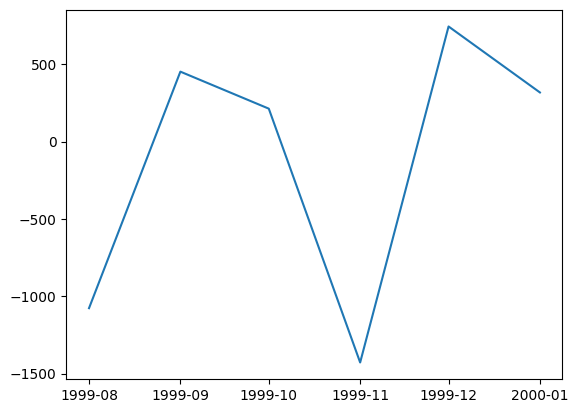

In [80]:
rolling_residuals=test_data-rolling_predictions
plt.plot(rolling_residuals)

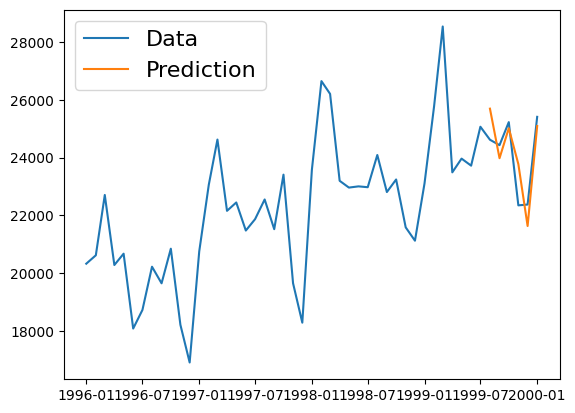

In [81]:
plt.plot(lim_catfish_sales)
plt.plot(rolling_predictions)
plt.legend(('Data','Prediction'),fontsize=16)

In [82]:
test_data

Date
1999-08-01    24618
1999-09-01    24430
1999-10-01    25229
1999-11-01    22344
1999-12-01    22372
2000-01-01    25412
Freq: MS, Name: Total, dtype: int64